In [76]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [77]:
def f(x):
    return 3*(x**2) - 4*x + 5

In [78]:
f(3.0)

20.0

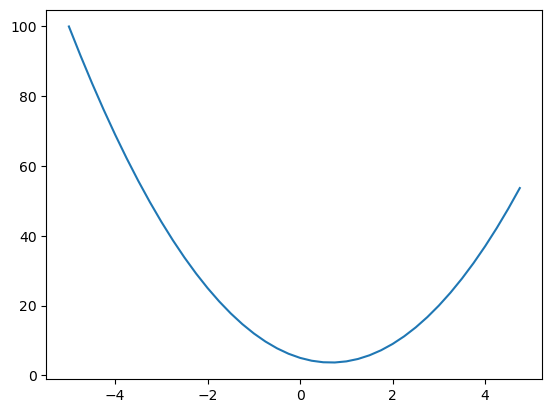

In [79]:
xs = np.arange(-5, 5, 0.25)
xs
ys = f(xs)
plt.plot(xs, ys)

In [80]:
h = 0.00000000001
x = -3.0
(f(x + h) - f(x)) / h

-21.999824184604222

In [81]:
h = 0.000000001
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
b += h
d2 = a*b + c
print("d1: ", d1)
print("d2: ", d2)
print("slope: ", (d2 - d1) / h)

d1:  4.0
d2:  4.000000002
slope:  2.000000165480742


In [82]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __sub__(self, other): # self - other
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data - other.data, (self, other), '-')

    def _backward():
      self.grad -= 1.0 * out.grad
      other.grad -= 1.0 * out.grad
    out._backward = _backward

    return out

  def __rsub__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(other.data - self.data)

    def _backward():
      self.grad -= -1.0 * out.grad
      other.grad -= 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()
    
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [83]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [84]:
# inputs
x1 = Value(2.0, label = "x1")
x2 = Value(0.0, label = "x2")
# weights
w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "w2")
# bias of the neuron
b = Value(6.8813735870195432, label = "b")
# x1w1 + x2w2 + b
x1w1 = x1 * w1
x1w1.label = "x1w1"
x2w2 = x2 * w2
x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b
n.label = "n"
o = n.tanh()
o.label = "o"

In [85]:
o.backward()

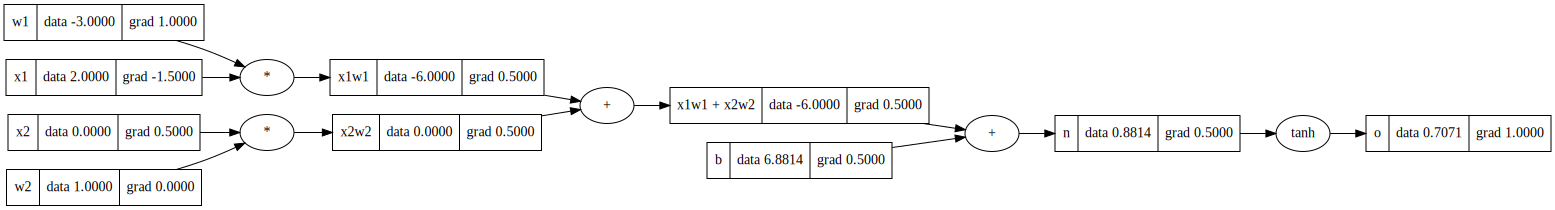

In [86]:
draw_dot(o)

In [87]:
# inputs
x1 = Value(2.0, label = "x1")
x2 = Value(0.0, label = "x2")
# weights
w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "w2")
# bias of the neuron
b = Value(6.8813735870195432, label = "b")
# x1w1 + x2w2 + b
x1w1 = x1 * w1
x1w1.label = "x1w1"
x2w2 = x2 * w2
x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b
n.label = "n"
e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = "o"

In [88]:
o.backward()

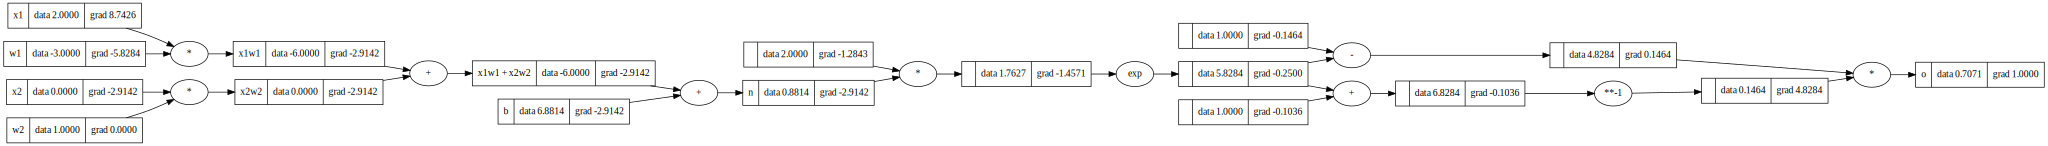

In [89]:
draw_dot(o)

In [90]:
import torch

x1 = torch.tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.tensor([1.0]).double(); w2.requires_grad = True
b = torch.tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()

print("___")
print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())

0.7071066904050358
___
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [91]:
import random

class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.28041352961235655)

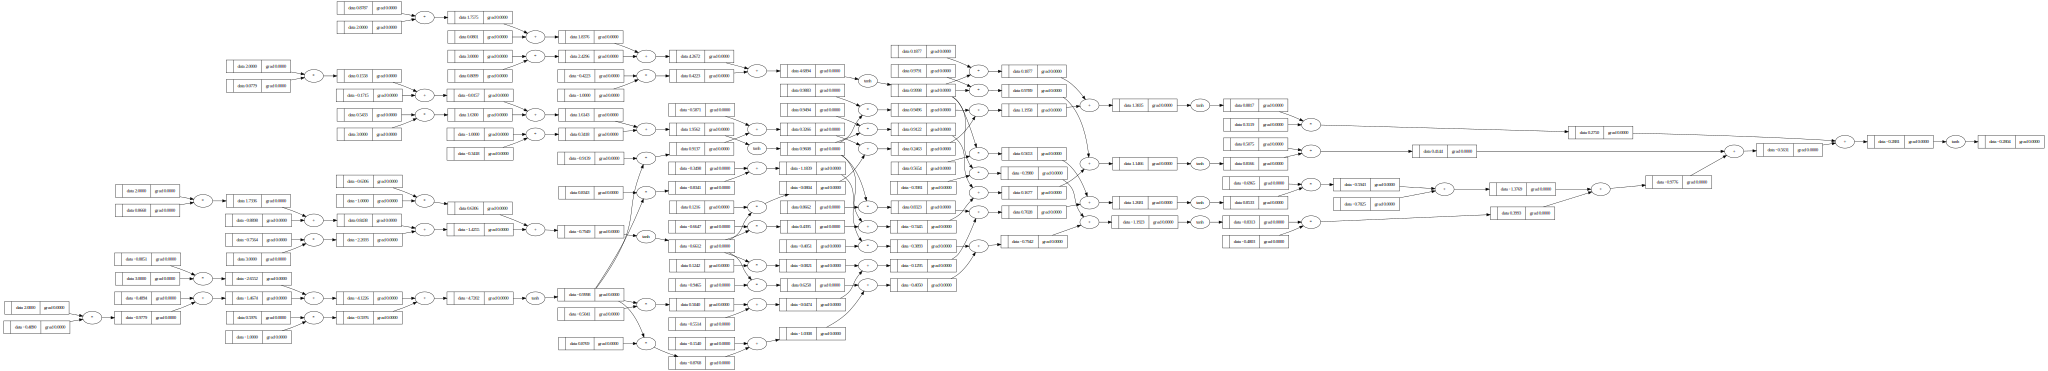

In [92]:
draw_dot(n(x))

In [93]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.28041352961235655),
 Value(data=-0.6514958741174371),
 Value(data=-0.4895702801900874),
 Value(data=-0.37915827321124695)]

In [94]:
loss = sum([(ygt - yout)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=3.923529974003796)

In [95]:
loss.backward()

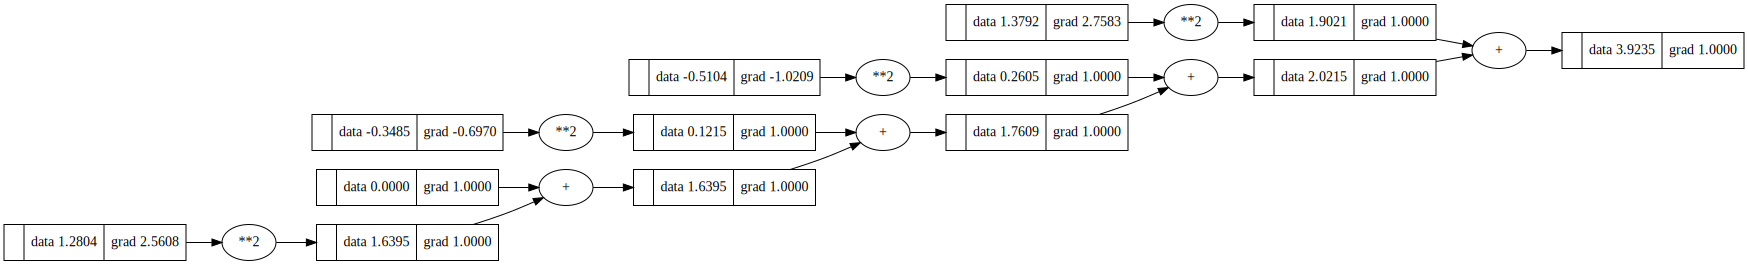

In [96]:
draw_dot(loss)